<a href="https://colab.research.google.com/github/karthikvijayakumar/EVA/blob/kvk_development/Project%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow
%matplotlib inline

Using TensorFlow backend.


In [2]:
model = VGG16(weights="imagenet")
model.summary()





553467904/553467096 [==============================] - 6s 0us/step


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________

In [3]:
#Below snippet taken from https://www.geeksforgeeks.org/downloading-files-web-using-python/

!pip install requests
import requests
image_url = "https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg"
r = requests.get(image_url)
with open("sunglasses.jpg",'wb') as f:   
    f.write(r.content) 

In [0]:
#Preprocessing the image for feeding to the model
img_path = "sunglasses.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
preds = model.predict(x)

# Using class 837 since 837 is the class index of sunglasses in the pretrained VGG model present in keras
# Ref: https://www.kaggle.com/keras/vgg16
class_idx = 837
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

In [6]:
print( decode_predictions(preds, top=10) )

40960/35363 [==================================] - 0s 0us/step
[[('n04356056', 'sunglasses', 0.33366656), ('n04355933', 'sunglass', 0.28235126), ('n04162706', 'seat_belt', 0.042528715), ('n03995372', 'power_drill', 0.031960417), ('n03763968', 'military_uniform', 0.018875215), ('n04141076', 'sax', 0.01664218), ('n04154565', 'screwdriver', 0.014779926), ('n02883205', 'bow_tie', 0.013530078), ('n04376876', 'syringe', 0.013300397), ('n04296562', 'stage', 0.01102321)]]


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0) # Clipping negative values 
heatmap /= np.max(heatmap)

In [0]:
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224) )
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

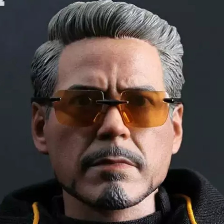

In [10]:
cv2_imshow(img)

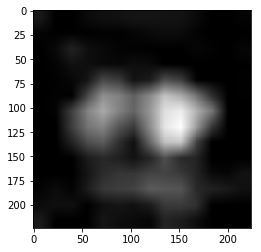

In [11]:
plt.imshow(heatmap, cmap='gray', vmin=0, vmax=255)

Min value: 0
Max value: 253


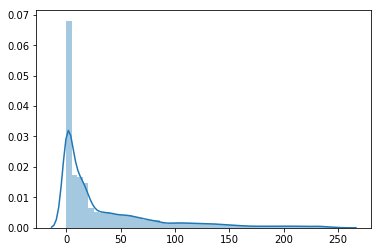

In [12]:
#Lets look at the distribution of the heatmap values
import seaborn as sns

print('Min value: ' + str(heatmap.min()) )
print('Max value: ' +  str(heatmap.max()) )

sns.distplot(heatmap.flatten())

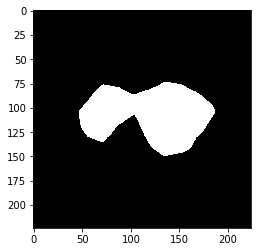

In [13]:
threshold = 90
# I chose this threshod using trial and error. Clearly this threshold might not work for a different image or class.
# I currently dont know what would be a scalable way to identify class bounding boxes using only the grad cam output

heatmap_thresholded = heatmap>threshold
heatmap_thresholded = np.uint8(255 * heatmap_thresholded)

plt.imshow(heatmap_thresholded, cmap='gray', vmin=0, vmax=255)

In [14]:
# The first axes is height and the second axis is width. The top left corner is (0,0)
min_x = np.argwhere(heatmap_thresholded>0)[:,1].min()
min_y = np.argwhere(heatmap_thresholded>0)[:,0].min()

max_x = np.argwhere(heatmap_thresholded>0)[:,1].max()
max_y = np.argwhere(heatmap_thresholded>0)[:,0].max()

print('min_x = ' + str(min_x))
print('min_y = ' + str(min_y))
print('max_x = ' + str(max_x))
print('max_y = ' + str(max_y))

min_x = 47
min_y = 74
max_x = 186
max_y = 149


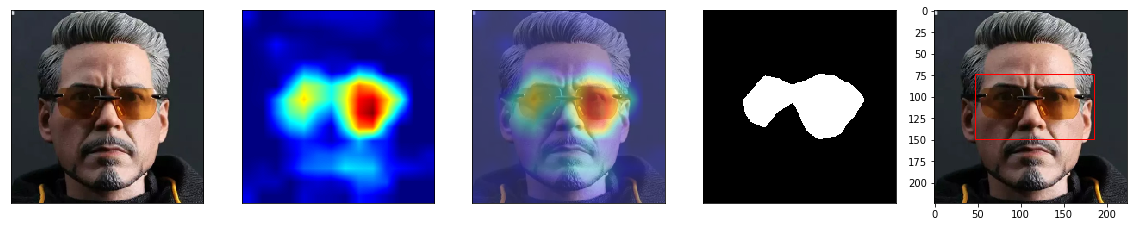

In [15]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,5, figsize = (20,4))
ax[0].imshow(img)
ax[0].set_xticks([],[])
ax[0].set_yticks([],[]);

ax[1].imshow(heatmap)
ax[1].set_xticks([],[])
ax[1].set_yticks([],[]);

ax[2].imshow(heatmap, alpha = 0.7)
ax[2].imshow(img, alpha = 0.5)
ax[2].set_xticks([],[])
ax[2].set_yticks([],[]);

ax[3].imshow(heatmap_thresholded, cmap='gray', vmin=0, vmax=255)
ax[3].set_xticks([],[])
ax[3].set_yticks([],[]);

ax[4].imshow(img)
rect = patches.Rectangle((min_x,min_y),(max_x-min_x),(max_y-min_y),linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax[4].add_patch(rect)

Images from left to right:

1. Input image
2. Heatmap from GradCAM
3. Overlay of heatmap on input image
4. Thresholded heatmap to indicate areas of maximum activation indicating area of the target object
5. Bounding box of the object overlayed on the input image

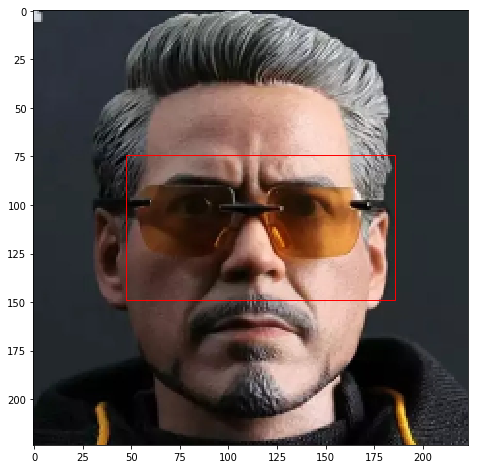

In [16]:
# Overaly of the bounding box of sunglasses on the input image again for clarity

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(img)
rect = patches.Rectangle((min_x,min_y),(max_x-min_x),(max_y-min_y),linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

Heatmaps from layers before the last convolution layers

In [0]:
"""
    Function assumes img in RGB space and not BGR space
"""
def get_heatmap_for_layer(conv_layer_name, num_channels, model, img, class_idx):
    class_output = model.output[:, class_idx]
    conv_layer = model.get_layer(conv_layer_name)
    grads = K.gradients(class_output, conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(num_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0) # Clipping negative values 
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap

In [0]:
heatmap_block5_conv2 = get_heatmap_for_layer('block5_conv2', 512, model,img, 837)
heatmap_block5_conv1 = get_heatmap_for_layer('block5_conv1', 512, model,img, 837)

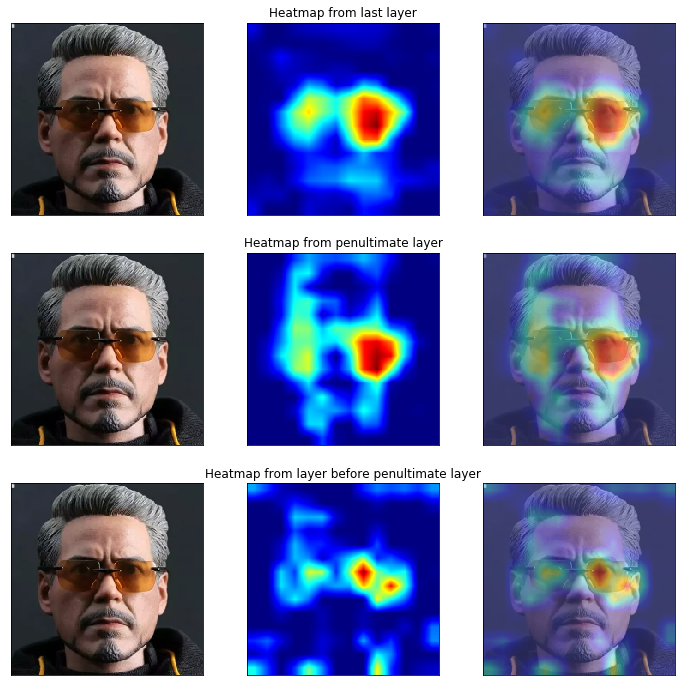

In [19]:
fig, ax = plt.subplots(3,3, figsize = (12,12))

#Heatmap from the last layer
ax[0][0].imshow(img)
ax[0][0].set_xticks([],[])
ax[0][0].set_yticks([],[]);

ax[0][1].imshow(heatmap)
ax[0][1].set_title('Heatmap from last layer')
ax[0][1].set_xticks([],[])
ax[0][1].set_yticks([],[]);

ax[0][2].imshow(heatmap, alpha = 0.7)
ax[0][2].imshow(img, alpha = 0.5)
ax[0][2].set_xticks([],[])
ax[0][2].set_yticks([],[]);

# Heatmap from the penultimate layer
ax[1][0].imshow(img)
ax[1][0].set_xticks([],[])
ax[1][0].set_yticks([],[]);

ax[1][1].imshow(heatmap_block5_conv2)
ax[1][1].set_title('Heatmap from penultimate layer')
ax[1][1].set_xticks([],[])
ax[1][1].set_yticks([],[]);

ax[1][2].imshow(heatmap_block5_conv2, alpha = 0.7)
ax[1][2].imshow(img, alpha = 0.5)
ax[1][2].set_xticks([],[])
ax[1][2].set_yticks([],[]);

# Heatmap from the layer before the penultimate layer
ax[2][0].imshow(img)
ax[2][0].set_xticks([],[])
ax[2][0].set_yticks([],[]);

ax[2][1].imshow(heatmap_block5_conv1)
ax[2][1].set_title('Heatmap from layer before penultimate layer')
ax[2][1].set_xticks([],[])
ax[2][1].set_yticks([],[]);

ax[2][2].imshow(heatmap_block5_conv1, alpha = 0.7)
ax[2][2].imshow(img, alpha = 0.5)
ax[2][2].set_xticks([],[])
ax[2][2].set_yticks([],[]);

We observe from the above heatmaps and overlays that the sunglasses were identified in a layer much before the last convolutional layer.

For some reason the left eye is more prominent in the grad cam output compared to the right eye. I dont know why this is happening. Using augmentation techniques like cutout could potentially improve this situation.

# Part 2

Computing receptive field for CNN used in the [paper](https://arxiv.org/pdf/1701.03056.pdf) 

The paper mentions in the description of figure 17 that all convolutions used in the network are 3x3 unless explicitly mentioned. This is a key point. Particularly this means the Conv/2 layers also use 3x3 kernels and not 2x2 kernels like we normally use in max pooling.

The 3x3 normal convolution layers ( "conv" layers ) use a padding of size 1 ( on each dimension ) to preserve the size of the output image.

Even the conv/2 layers use a padding of size 1 ( on each dimension ), else the output image sizes from the conv/2 layers would not be exact half of their corresponding input layers.

The receptive field computation works out as follows:


| Layer name/type | Input size | kernel size | padding | stride | jump in | receptive field in | output size | jump out | receptive field out |
|-----------------|------------|-------------|---------|--------|---------|--------------------|-------------|----------|---------------------|
| conv            | 128        | 3           | 1       | 1      | 1       | 1                  | 128         | 1        | 3                   |
| conv/2          | 128        | 3           | 1       | 2      | 1       | 3                  | 64          | 2        | 5                   |
| conv            | 64         | 3           | 1       | 1      | 2       | 5                  | 64          | 2        | 9                   |
| conv/2          | 64         | 3           | 1       | 2      | 2       | 9                  | 32          | 4        | 13                  |
| conv            | 32         | 3           | 1       | 1      | 4       | 13                 | 32          | 4        | 21                  |
| conv/2          | 32         | 3           | 1       | 2      | 4       | 21                 | 16          | 8        | 29                  |
| conv            | 16         | 3           | 1       | 1      | 8       | 29                 | 16          | 8        | 45                  |